In [39]:
# TODO:
# - How are F1s aggregated?

In [40]:
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore') 

Populating the interactive namespace from numpy and matplotlib


In [26]:
filename = '/Users/alexbw/Downloads/fingerprints.pkl'

In [27]:
with open(filename, 'rb') as f:
    fingerprints, fingerprint_labels = pickle.load(f, encoding='latin1')

In [28]:
def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)\
               .split(features, labels)
    train_ind, test_ind = next(splits)
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', multi_class='ovr', class_weight='balanced')
    model.fit(features[train_ind], labels[train_ind])
    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return true_labels, pred_labels, scores

## Choose a label level

In [29]:
label_level = 'drug' # also valid: class, dose
y = fingerprint_labels[f'y_{label_level}']
unique_labels = fingerprint_labels[f'unique_{label_level}']
n_labels = len(unique_labels)

## Train a Classifier on MoSeq, Scalars and Shuffled Data

## Calculate F1 scores and Precision-Recall Curves

In [11]:
y = fingerprint_labels['y_drug']
for feature_type in ['moseq', 'scalars', 'shuffled_moseq']:

    x = fingerprints[feature_type]
        
    f1s = []
    for iseed in range(100):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed)
        mean_f1 = np.mean([f1_score(true_labels==i, pred_labels==i) for i in range(n_labels)])
        f1s.append(mean_f1)

    print(f'{feature_type}: {np.mean(f1s):.2f} ± {np.std(f1s):.2f}')

moseq: 0.59 ± 0.04
scalars: 0.40 ± 0.05
shuffled_moseq: 0.06 ± 0.02


## Cosine Distances Between Treatments

In [36]:
cosine = lambda data: squareform(pdist(data,metric='cosine'))

def sim_matrix_of_avgs(data,labels):
    # Get the per-label average of the data
    unique_labels = np.unique(labels)
    out = np.zeros((len(unique_labels),len(unique_labels)),dtype='float32')
    means = np.zeros((len(unique_labels),data.shape[1]))
    for ilabel in unique_labels:
        means[ilabel] = np.nanmean(data[labels==ilabel],0)
    return cosine(means)

def show_cosine(data):
    return imshow(sim_matrix_of_avgs(data, fingerprint_labels['y_drug']),
                  cmap='viridis_r',
                  clim=(0,1.0),
                  interpolation=None); axis('square')


short_name_map = OrderedDict([
    ('alprazolam','ALPR'),
    ('atomoxetine','ATOM'),
    ('bupropion','BUPR'),
    ('chlorpromazine','CHLO'),
    ('citalopram','CITA'),
    ('clozapine','CLOZ'),
    ('control','CTRL'),
    ('diazepam','DIAZ'),
    ('fluoxetine','FLUO'),
    ('haloperidol','HALO'),
    ('methamphetamine','METH'),
    ('methylphenidate','MTPH'),
    ('modafinil','MODA'),
    ('phenelzine','PHEN'),
    ('risperidone','RISP'),
    ('venlafaxine','VENL'),
])
short_names = [short_name_map[u] for u in unique_labels]

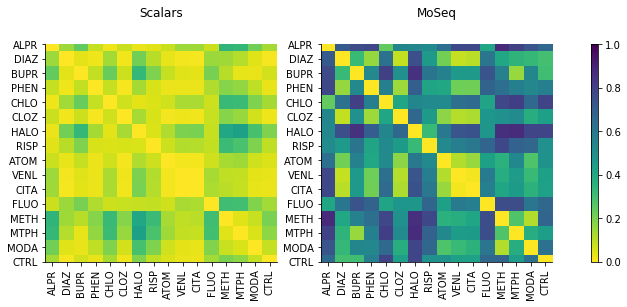

In [37]:
figure(figsize=(10,4))
gs = GridSpec(1,3, width_ratios=[10,10,0.3])

ax = subplot(gs[0])
cax = show_cosine(fingerprints['scalars'])
title('Scalars', y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[1])
show_cosine(fingerprints['moseq'])
title('MoSeq',y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[2])
colorbar(cax, cax=ax);

## LDA Visualization of Mice Across Treatments

In [42]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(fingerprints['moseq'], fingerprint_labels['y_drug'])
p = lda.transform(fingerprints['moseq'])

In [47]:
drug_class = fingerprint_labels['drug_class']
unique_class = [b for a,b in zip([""]+drug_class,drug_class) if b!=a]
drug = fingerprint_labels['drug']
unique_drug = [b for a,b in zip([""]+drug,drug) if b!=a]

In [48]:
color_map = dict(zip(unique_class, sns.color_palette(palette='Paired', n_colors=len(unique_class))))
class_per_drug = []

colors_ = []
for drug_ in unique_drug:
    class_ = np.array(drug_class)[np.array(drug)==drug_][0]
    colors_.append(color_map[class_])

Text(0, 0.5, 'LDA 2')

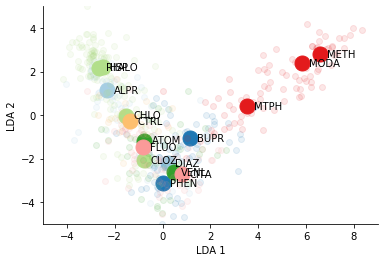

In [51]:
for i, treatment in enumerate(unique_drug):
    idx = fingerprint_labels['y_drug'] == i
    plot(p[idx, 0], p[idx, 1], 'o', alpha=0.1, color=colors_[i])
    x, y = np.mean(p[idx], axis=0)
    plot(x, y, 'o',
         markersize=15, color=colors_[i], label=short_name_map[treatment])
    text(x + 0.3, y, short_name_map[treatment], fontsize=10, verticalalignment='center', )
    
sns.despine()
# legend(loc='center left', bbox_to_anchor=[1,0.5])
ylim(-5, 5)
xlim(-5, 9)
xlabel('LDA 1')
ylabel('LDA 2')

## Syllable Importance Calculation